In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from sklearn.linear_model import LinearRegression
import glob
import scipy
from functools import reduce

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker


In [2]:
def get_month_start_days():
    return pd.date_range('2023-01-01', '2023-12-31', freq='MS').dayofyear.tolist()

def get_month_start_labels():
    return pd.date_range('2023-01-01', '2023-12-31', freq='MS').strftime('%m-%d').tolist()

def get_95CI(signal, alpha = 5.0):
    signal.index = pd.to_numeric(signal.index)

    CI95_lower = []
    CI95_upper = []

    for timestep in range(signal.shape[0]):

        # Gather the samples at time t:
        drawn_at_time_t = signal.loc[timestep].values

        # Computes the lower bound:
        lower_p = alpha / 2.0
        
        # Retrieves the observation at the lower percentile index:
        lower = np.percentile(drawn_at_time_t, lower_p)

        # Computes the upper bound:
        upper_p = (100 - alpha) + (alpha / 2.0)
        
        # Retrieves the observation at the upper percentile index:
        upper = np.percentile(drawn_at_time_t, upper_p)

        CI95_lower.append(lower)
        CI95_upper.append(upper)
        
    return CI95_lower, CI95_upper

def model_3_estimation(full_obs_matrix, obs_matrix, QIj_vect, parameter_index, components):
    variables = ['NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']

    new_QIj_vect = []
    valeur_theorique_param = QIj_vect[parameter_index]
    
    for i in range(7):
        factor = (full_obs_matrix[:,i] / full_obs_matrix[:,parameter_index]).mean()
        new_QIj_vect.append(factor * valeur_theorique_param)
    
    new_QIj_vect = np.array(new_QIj_vect)
    new_QIj_vect
    
    print("==============")
    print(new_QIj_vect)
    print(parameter_index)
    print("==============")

    nb_components = len(components)
    
    sub_obs_matrix = obs_matrix.copy()
    sub_new_QIj_vect = new_QIj_vect.copy()
    sub_obs_matrix = sub_obs_matrix[:, components]
    sub_new_QIj_vect = sub_new_QIj_vect[components]

    print("---------")
    print(components)
    print(np.array(variables)[components])
    print(sub_obs_matrix.shape, sub_new_QIj_vect.shape)
    print("---------")

    ####
    this_pointwise_Nt_hat = []
    
    for t in range(sub_obs_matrix.shape[0]):
    
        def params_estimation(theta):
            this_y = sub_obs_matrix[t]
            this_alpha = sub_new_QIj_vect
            this_beta = np.zeros(sub_obs_matrix.shape[1])
        
            this_alpha_theta = this_alpha * theta[0]

            for this_index in range(nb_components):     
                if this_index!=parameter_index:
                    this_beta[this_index] = theta[this_index+1]

            return np.linalg.norm(this_y - this_alpha_theta - this_beta)
    
    
        res = scipy.optimize.minimize(params_estimation, x0=np.ones(sub_obs_matrix.shape[1]+1))
        this_pointwise_Nt_hat.append(res['x'][0])

    return this_pointwise_Nt_hat

filepath = "../data/samples_quantifications.xlsx"

def get_raw_data(wwtp):
    if wwtp == 'MAV':
        raw_data = pd.read_excel(filepath, sheet_name='MAV')
        raw_data = raw_data.loc[1:]
        raw_data = raw_data.rename(columns={'MAV':'dateStart',
                                           'Débit Total station':'plantVolume'})
    
        raw_data.dateStart = pd.to_datetime(raw_data.dateStart)
        raw_data.plantVolume = pd.to_numeric(raw_data.plantVolume)
        raw_data.NH4 = pd.to_numeric(raw_data.NH4)
        raw_data.NTK = pd.to_numeric(raw_data.NTK)
        raw_data.DCO = pd.to_numeric(raw_data.DCO)
        raw_data.DBO = pd.to_numeric(raw_data.DBO)
        raw_data.MES = pd.to_numeric(raw_data.MES)
        raw_data.NGL = pd.to_numeric(raw_data.NGL)
        raw_data.PT = pd.to_numeric(raw_data.PT)
        
        raw_data['month'] = raw_data.dateStart.dt.month
        raw_data['year'] = raw_data.dateStart.dt.year
        raw_data['day'] = raw_data.dateStart.dt.dayofyear
    
    elif wwtp == 'SEC':
        raw_data = pd.read_excel(filepath, sheet_name='SEC')
        raw_data = raw_data.loc[1:]
        raw_data = raw_data.rename(columns={'SEC':'dateStart',
                                           'Débit Total station':'plantVolume'})
    
        raw_data.dateStart = pd.to_datetime(raw_data.dateStart)
        raw_data.plantVolume = pd.to_numeric(raw_data.plantVolume)
        raw_data.NH4 = pd.to_numeric(raw_data.NH4)
        raw_data.NTK = pd.to_numeric(raw_data.NTK)
        raw_data.DCO = pd.to_numeric(raw_data.DCO)
        raw_data.DCO = pd.to_numeric(raw_data.DBO)
        raw_data.MES = pd.to_numeric(raw_data.MES)
        raw_data.NGL = pd.to_numeric(raw_data.NGL)
        raw_data.PT = pd.to_numeric(raw_data.PT)
        
        raw_data['month'] = raw_data.dateStart.dt.month
        raw_data['year'] = raw_data.dateStart.dt.year
        raw_data['day'] = raw_data.dateStart.dt.dayofyear

        # changing SEC volumes for Clichy:    
        volumes_clichy = process_vc()
        
        subraw_data = raw_data.copy()
        subraw_data = subraw_data.loc[~subraw_data.dateStart.isna()]
        subraw_data = subraw_data.loc[subraw_data.dateStart.isin(volumes_clichy.dateStart)]
        
        subraw_data.loc[subraw_data.plantVolume==0, 'plantVolume'] = 1 
        subraw_data = subraw_data.drop('plantVolume', axis=1)
        subraw_data.set_index('dateStart', inplace=True)
        volumes_clichy.set_index('dateStart', inplace=True)
        subraw_data = subraw_data.join(volumes_clichy['plantVolume'])
        subraw_data.reset_index(inplace=True)
    
        raw_data = subraw_data.copy()
        raw_data = raw_data.loc[(raw_data.year>=2021)&(raw_data.dateStart<='2024-12-25')]
        raw_data.reset_index(inplace=True)
    
    
    elif wwtp == 'SEV':
        raw_data = pd.read_excel(filepath, sheet_name='SEV')
        raw_data = raw_data.loc[1:]
        raw_data = raw_data.rename(columns={'SEV':'dateStart',
                                           'Débit Total station':'plantVolume'})
    
        raw_data.dateStart = pd.to_datetime(raw_data.dateStart)
        raw_data.plantVolume = pd.to_numeric(raw_data.plantVolume)
        raw_data.NH4 = pd.to_numeric(raw_data.NH4)
        raw_data.NTK = pd.to_numeric(raw_data.NTK)
        raw_data.DCO = pd.to_numeric(raw_data.DCO)
        raw_data.DBO = pd.to_numeric(raw_data.DBO)
        raw_data.MES = pd.to_numeric(raw_data.MES)
        raw_data.NGL = pd.to_numeric(raw_data.NGL)
        raw_data.PT = pd.to_numeric(raw_data.PT)
        
        raw_data['month'] = raw_data.dateStart.dt.month
        raw_data['year'] = raw_data.dateStart.dt.year
        raw_data['day'] = raw_data.dateStart.dt.dayofyear

    return raw_data

def get_obs_matrix(wwtp):
    
    raw_data = get_raw_data(wwtp)
    raw_data = raw_data.loc[raw_data.year>=2020].copy()
    raw_data.reset_index(inplace=True, drop=True)
    files = glob.glob("../outputs/files/pop_estimation_" + wwtp +  "_hierarchical_manuscript/*.csv")

    smoothed_wwtp_dict = {}
    smoothed_wwtp_dict_CIL = {}
    smoothed_wwtp_dict_CIU = {}
    
    # MAV
    for indicator in ['NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']:
        this_file = indicator + '.csv'
    
        for this_path in files:
            if this_file in this_path:
                this_traces = pd.read_csv(this_path, sep=';')
                this_mean_trace = this_traces.muX.values
                this_CIL, this_CIU = this_traces.ICL.values, this_traces.ICU.values
                smoothed_wwtp_dict[indicator] = this_mean_trace
                smoothed_wwtp_dict_CIL[indicator] = this_CIL
                smoothed_wwtp_dict_CIU[indicator] = this_CIU
                
    obs_matrix_CIL = np.array(list(smoothed_wwtp_dict_CIL.values())).T
    obs_matrix_CIL = 10**(obs_matrix_CIL)
    obs_matrix_CIU = np.array(list(smoothed_wwtp_dict_CIU.values())).T
    obs_matrix_CIU = 10**(obs_matrix_CIU)
    
    obs_matrix = np.array(list(smoothed_wwtp_dict.values())).T
    obs_matrix = 10**(obs_matrix)

    return raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU

def plot_indicators(raw_data, obs_matrix, QIj_vect):

    colors = ['royalblue', 'green', 'orange', 'gold', 'gray', 'teal', 'fuchsia',
             'purple', 'lime', 'black']
    
    keys_list = ['A', 'B', 'C', 
                 'D', 'E', 'F',
                 'G']
    
    indicators_list = ['NH4+', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']
    
    with plt.style.context(['science', 'notebook', 'grid']):
            
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        #figsize = (96, 60)
        figsize = (32, 20)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            ABC
            DEF
            GHI
            """
        )
    
    
        for index, key in enumerate(keys_list):
    
            ax_dict[key].plot(raw_data.dateStart.values, obs_matrix[:,index] / obs_matrix[:,0] ,
                                 label='Population estimée', color=colors[index],
                                 linewidth=5)
    
            ax_dict[key].plot(raw_data.dateStart.values, (np.ones(obs_matrix.shape[0]) * QIj_vect[index]) / QIj_vect[0],
                                 label='Theoretical ratio', color='red',
                                 linewidth=5)
    
            
    
            ax_dict[key].set_title(indicators_list[index], size=TITLE_SIZE)
            ax_dict[key].set_ylabel("Ratio par rapport à $NH_4^+$", size=LABEL_SIZE)
            ax_dict[key].set_xlabel("Sampling date", size=LABEL_SIZE)
            ax_dict[key].tick_params(axis='x', labelsize=TICK_SIZE)
            ax_dict[key].tick_params(axis='y', labelsize=TICK_SIZE)
            ax_dict[key].tick_params(axis='x', rotation=45)
    
    
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        fig.legend(h1, l1, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    
        plt.show()

def get_new_QIj_vect_and_CIs(obs_matrix):
    new_QIj_vect = []
    new_QIj_vect_CIL = []
    new_QIj_vect_CIU = []
    valeur_theorique_NGL = 12.6
    
    for i in range(7):
        factor = (obs_matrix[:,i] / obs_matrix[:,4]).mean()
        new_QIj_vect.append(factor * valeur_theorique_NGL)
    
        lower_factor = np.percentile(obs_matrix[:,i] / obs_matrix[:,4], 2.5)
        upper_factor = np.percentile(obs_matrix[:,i] / obs_matrix[:,4], 97.5)
    
        new_QIj_vect_CIL.append(lower_factor * valeur_theorique_NGL)
        new_QIj_vect_CIU.append(upper_factor * valeur_theorique_NGL)
    
    new_QIj_vect = np.array(new_QIj_vect)
    new_QIj_vect_CIL = np.array(new_QIj_vect_CIL)
    new_QIj_vect_CIU = np.array(new_QIj_vect_CIU)
    
    print(new_QIj_vect_CIL)
    print(new_QIj_vect)
    print(new_QIj_vect_CIU)

In [3]:
def find_breakpoints(input_data, indicator, threshold=21):
    previous_date = input_data.dateStart.tolist()[0]
    elapsed_times = []
    dates_elapsed_dict = {}
    
    for row in input_data.index.tolist():
        if np.isnan(input_data.loc[row, indicator]):
            continue
            
        this_date = input_data.loc[row, 'dateStart']
        elapsed_time = (this_date - previous_date).days
        elapsed_times.append(elapsed_time)
        previous_date = this_date
    
        dates_elapsed_dict[this_date]=elapsed_time

    breakpoints = []
    for idx, key in enumerate(list(dates_elapsed_dict.keys())):
        if dates_elapsed_dict[key] > threshold:
            previous_key = list(dates_elapsed_dict.keys())[idx-1]
            breakpoints.append(previous_key)
            breakpoints.append(key)
    
    return breakpoints

def get_sub_df(df, breakpoints):
    p = len(breakpoints)
    if p==2:
        sub_df_1 = df.loc[df.dateStart<=breakpoints[0]]
        sub_df_2 = df.loc[df.dateStart>=breakpoints[-1]]
        concat_df = pd.concat((sub_df_1, sub_df_2))
    
    elif p>2:
        concat_df = pd.DataFrame()
        keep_these_data = 1
        for idx, bp in enumerate(breakpoints):
            if idx==0:
                temp_df = df.loc[df.dateStart<=breakpoints[0]]
            elif idx==p-1:
                temp_df = df.loc[df.dateStart>=breakpoints[-1]]
            else:
                if keep_these_data==1:
                    temp_df = df.loc[(df.dateStart>=bp) & (df.dateStart<=breakpoints[idx+1])]
                    keep_these_data=0
                else:
                    temp_df = pd.DataFrame()

            concat_df = pd.concat((concat_df, temp_df))

    elif p==0:
        concat_df = df.copy()
            

    return concat_df

In [4]:
def model_been_et_al(obs_matrix, QIj_vect):
    variables = ['NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']

    new_QIj_vect = QIj_vect.copy()
    NT_hat_combis = {}

    print("==============")
    print(new_QIj_vect)
    print("==============")

    components = [4]
    nb_components = len(components)
    
    sub_obs_matrix = obs_matrix.copy()
    sub_new_QIj_vect = new_QIj_vect.copy()
    sub_obs_matrix = sub_obs_matrix[:, components]
    sub_new_QIj_vect = sub_new_QIj_vect[components]

    print("---------")
    print(components)
    print(np.array(variables)[components])
    print(sub_obs_matrix.shape, sub_new_QIj_vect.shape)
    print("---------")

    ####
    this_pointwise_Nt_hat = []
    x = sub_new_QIj_vect
    for t in range(sub_obs_matrix.shape[0]):
        y = sub_obs_matrix[t]
        lr = LinearRegression(fit_intercept=False)
        lr.fit(x.reshape(-1,1), y)
        this_pointwise_Nt_hat.append(lr.coef_[0])

    return this_pointwise_Nt_hat

def model_vn_et_al(obs_matrix, QIj_vect, component_index):
    variables = ['NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES']

    new_QIj_vect = QIj_vect.copy()
    NT_hat_combis = {}

    print("==============")
    print(new_QIj_vect)
    print("==============")

    components = [component_index]
    nb_components = len(components)
    
    sub_obs_matrix = obs_matrix.copy()
    sub_new_QIj_vect = new_QIj_vect.copy()
    sub_obs_matrix = sub_obs_matrix[:, components]
    sub_new_QIj_vect = sub_new_QIj_vect[components]

    print("---------")
    print(components)
    print(np.array(variables)[components])
    print(sub_obs_matrix.shape, sub_new_QIj_vect.shape)
    print("---------")

    ####
    this_pointwise_Nt_hat = []
    x = sub_new_QIj_vect
    for t in range(sub_obs_matrix.shape[0]):
        y = sub_obs_matrix[t]
        lr = LinearRegression(fit_intercept=False)
        lr.fit(x.reshape(-1,1), y)
        this_pointwise_Nt_hat.append(lr.coef_[0])

    return this_pointwise_Nt_hat

In [5]:
mapping_dict = {'janvier': '01', 'février': '02', 'mars': '03', 'avril': '04', 'mai': '05',
                              'juin':'06', 'juillet':'07', 'août':'08', 'septembre':'09', 'octobre':'10', 
                              'novembre':'11', 'décembre':'12'}

In [6]:
def process_vc(vc_path="../data/Débit sur Clichy 2021 - 2024.xlsx"):
    volumes_clichy = pd.read_excel(vc_path, sheet_name="Données")
    volumes_clichy = volumes_clichy.loc[1:]
    volumes_clichy.columns = ['dateStart', 'plantVolume']
    
    volumes_clichy_first_part = volumes_clichy.loc[:1095].copy()
    volumes_clichy_second_part = volumes_clichy.loc[1096:].copy()
    volumes_clichy_first_part.dateStart = pd.to_datetime(volumes_clichy_first_part.dateStart)
    
    volumes_clichy_second_part['dateStart'] = volumes_clichy_second_part['dateStart'].apply(
        lambda x: reduce(lambda s, kv: s.replace(*kv), mapping_dict.items(), str(x)))
    
    volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x[:-2] + '2024')
    
    volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: x.split(' ')[1:])
    
    volumes_clichy_second_part.dateStart.apply(lambda x: x.reverse())
    volumes_clichy_second_part.dateStart = volumes_clichy_second_part.dateStart.apply(lambda x: '-'.join(x))
    volumes_clichy_second_part.dateStart = pd.to_datetime(volumes_clichy_second_part.dateStart)
    
    volumes_clichy.dateStart = volumes_clichy_first_part.dateStart.tolist() + volumes_clichy_second_part.dateStart.tolist()
    
    volumes_clichy.plantVolume = pd.to_numeric(volumes_clichy.plantVolume)
    return volumes_clichy

In [7]:
def full_process_IAGE(iage_filepath):
    data_cp = pd.read_csv(iage_filepath, sep=";")
    data_cp.dateStart = pd.to_datetime(data_cp.dateStart)
    
    for col in ['obs', 'muX', 'ICL', 'ICU']:
        data_cp[col] = 10**(data_cp[col])
    
    fd, ld = data_cp.dateStart.tolist()[0], data_cp.dateStart.tolist()[-1]
    
    if 'MAV' in iage_filepath:
        wwtp = 'MAV'
    elif 'VAL' in iage_filepath:
        wwtp = 'SEV'
    elif 'SEC' in iage_filepath:
        wwtp = 'SEC'
    
    raw_data, obs_matrix, obs_matrix_CIL, obs_matrix_CIU = get_obs_matrix(wwtp)
    those_idx = raw_data.loc[(raw_data.dateStart>=fd)&(raw_data.dateStart<=ld)].index.tolist()
    
    
    obs_matrix = obs_matrix[those_idx]
    obs_matrix_CIL = obs_matrix_CIL[those_idx]
    obs_matrix_CIU = obs_matrix_CIU[those_idx]
    raw_data = raw_data.loc[those_idx]
    
    remove_those = raw_data.loc[raw_data.DCO.isna()|(raw_data.plantVolume.isna())].index.tolist()
    
    raw_obs_matrix = raw_data.loc[::, ['NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES', 'plantVolume']]
    for k in range(7):
        raw_obs_matrix.iloc[:, k] *= raw_obs_matrix.iloc[:, -1]

    raw_obs_matrix.drop(remove_those, axis=0, inplace=True)
    raw_obs_matrix = raw_obs_matrix.values
    raw_obs_matrix = raw_obs_matrix[:,:-1]
    
    'NH4', 'DCO', 'DBO', 'NTK', 'NGL', 'PT', 'MES'
    QIj_vect = np.array([10.3, 120, 60, 12.6, 12.6, 1.2, 60])
    
    
    k = 4
    components = [0, 1, 2, 3, 4]
    
    this_NT_hat = model_3_estimation(obs_matrix, obs_matrix, QIj_vect, k, components)
    raw_data['Nt_hat'] = this_NT_hat

    # preprocessing for vn et al
    #obs_matrix = pd.DataFrame(obs_matrix)
    #obs_matrix.set_index(np.arange(raw_obs_matrix.index.tolist()[0], raw_obs_matrix.index.tolist()[-1] + 1), inplace=True)
    #raw_obs_matrix.drop(remove_those, axis=0, inplace=True)
    #obs_matrix.drop(remove_those, axis=0, inplace=True)
    #obs_matrix = obs_matrix.values
    #raw_obs_matrix = raw_obs_matrix.values
    #raw_obs_matrix = raw_obs_matrix[:,:-1]

    #smoothed
    those_NT_hats = []
    for component in [1, 2, 4, 5]:
        temp = model_vn_et_al(obs_matrix, QIj_vect, component)
        those_NT_hats.append(temp)
    
    those_NT_hats = np.array(those_NT_hats)
    this_NT_hat_vn = those_NT_hats.mean(axis=0)    
    raw_data['Nt_hat_vn_smoothed'] = this_NT_hat_vn
    # raw
    
    those_NT_hats = []
    for component in [1, 2, 4, 5]:
        temp = model_vn_et_al(raw_obs_matrix, QIj_vect, component)
        those_NT_hats.append(temp)
    
    those_NT_hats = np.array(those_NT_hats)
    this_NT_hat_vn = those_NT_hats.mean(axis=0)
    
    df_idxes = np.setxor1d(those_idx, remove_those)
    df_NT_vn = pd.DataFrame()
    df_NT_vn['Nt_hat'] = this_NT_hat_vn
    df_NT_vn.set_index(df_idxes, inplace=True)
    
    this_NT_hat_vn_filled = []
    for row in (raw_data.index.tolist()):
        if row in remove_those:
            this_NT_hat_vn_filled.append(np.nan)
        else:
            this_NT_hat_vn_filled.append(df_NT_vn.loc[row, 'Nt_hat'])
    
    raw_data['Nt_hat_vn'] = this_NT_hat_vn_filled
    pop_file = raw_data.copy()

    # new
    pop_file.drop('Nt_hat', axis=1, inplace=True)
    final_filepath = '../outputs/files/ww_estimator/df_' + wwtp +'_final_crAssPMMoV.csv'
    df_final_wwtp = pd.read_csv(final_filepath, sep=";")
    df_final_wwtp.dateStart = pd.to_datetime(df_final_wwtp.dateStart)
    df_final_wwtp = df_final_wwtp.rename(columns={'Nt_hat_4':'Nt_hat'})
    pop_file = pop_file.merge(df_final_wwtp.loc[::, ['dateStart', 'Nt_hat']], on='dateStart')
    # end new
    

    breakpoints_ml = []#find_breakpoints(data_cp, indicator='obs')
    breakpoints_pop = find_breakpoints(pop_file, indicator='NTK')
    s1 = get_sub_df(data_cp, breakpoints_ml)
    #s2 = get_sub_df(pop_file, breakpoints_pop)
    s2 = pop_file.loc[~pop_file.Nt_hat_vn.isna()]

    common_dates = np.intersect1d(s1.dateStart.values, s2.dateStart.values)
    s1 = s1.loc[s1.dateStart.isin(common_dates)]
    s2 = s2.loc[s2.dateStart.isin(common_dates)]


    with plt.style.context(['science', 'notebook', 'grid']):
    
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        figsize = (28, 10) #figsize = (32, 10)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            A
            """
        )
        
        ### A
        ax_dict['A'].plot(pop_file.dateStart.values, pop_file.Nt_hat.values, linewidth=10, zorder=3, color='orange')
        ax_dict['A'].plot(pop_file.dateStart.values, pop_file.Nt_hat.values, color='black', linewidth=3, zorder=3)
    
        ax_dict['A'].plot(pop_file.dateStart.values, pop_file.Nt_hat_vn.values, linewidth=3, zorder=3, color='lightseagreen')
        ax_dict['A'].plot(pop_file.dateStart.values, pop_file.Nt_hat_vn_smoothed.values, linewidth=3, zorder=3, color='darkorchid')
        
        ax_cases = ax_dict['A'].twinx()
    
        ax_cases.plot(data_cp.dateStart.values, data_cp.muX.values, linewidth=10, zorder=3)
        ax_cases.plot(data_cp.dateStart.values, data_cp.muX.values, color='black', linewidth=3, zorder=3)
        

    
        ax_cases.scatter(data_cp.dateStart.values, data_cp.obs.values)
        ax_cases.scatter(s1.dateStart.values, s1.muX.values, color='red', s=540)
        ax_dict['A'].scatter(s2.dateStart.values, s2.Nt_hat.values, color='red', s=540)
    
        for bp in breakpoints_ml:
            ax_cases.axvline(bp, linewidth=5, color='dodgerblue')

        for bp in breakpoints_pop:
            ax_cases.axvline(bp, linewidth=5, color='orange')
        
        # Main legend
        plt.rcParams['text.usetex'] = False
        h1, l1 = ax_dict['A'].get_legend_handles_labels()
        h2, l2 = ax_cases.get_legend_handles_labels()
        fig.legend(h1+h2, l1+l2, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=3)
        #plt.savefig("../outputs/figs/" + this_molecule + ".pdf", bbox_inches = 'tight')
        #plt.savefig("../outputs/figs/" + this_molecule + ".jpg", bbox_inches = 'tight')
        
        plt.show()

    lr = LinearRegression()
    lr.fit(s1.muX.values.reshape(-1,1), s2.Nt_hat.values)


    with plt.style.context(['science', 'notebook', 'grid']):
    
        LABEL_SIZE = 30
        TICK_SIZE = 30
        TITLE_SIZE = 38
        LEGEND_SIZE = 30
        DATES_SIZE = 18
        figsize = (28, 5) #figsize = (32, 10)
        
        plt.rc('axes', labelsize=LABEL_SIZE)
        plt.rc('xtick', labelsize=TICK_SIZE)   
        plt.rc('ytick', labelsize=TICK_SIZE)
        plt.rc('figure', titlesize=TITLE_SIZE)
        plt.rc('legend', fontsize=LEGEND_SIZE)
        plt.rcParams['text.usetex'] = True
        
        fig = plt.figure(figsize=figsize, layout="constrained")
        
        ax_dict = fig.subplot_mosaic(
            """
            ABC
            """
        )

        
        # A 
        lr = LinearRegression()
        lr.fit(s1.muX.values.reshape(-1,1), s2.Nt_hat.values)

        ax_dict['A'].scatter(s1.muX.values, s2.Nt_hat.values, s=360, color='orange', edgecolor='black')
        ax_dict['A'].plot(s1.muX.values, lr.predict(s1.muX.values.reshape(-1,1)), linewidth=10, color='crimson')
        ax_dict['A'].plot(s1.muX.values, lr.predict(s1.muX.values.reshape(-1,1)), linewidth=3, color='black')

        # B
        s2_temp = s2.copy()
        s2_temp = s2_temp.loc[~s2_temp.Nt_hat_vn.isna()]
        lr = LinearRegression()
        lr.fit(s2_temp.Nt_hat_vn.values.reshape(-1,1), s2_temp.Nt_hat.values)

        ax_dict['B'].scatter(s2_temp.Nt_hat_vn.values, s2_temp.Nt_hat.values, s=360, color='orange', edgecolor='black')
        ax_dict['B'].plot(s2_temp.Nt_hat_vn.values, lr.predict(s2_temp.Nt_hat_vn.values.reshape(-1,1)), linewidth=10, color='crimson')
        ax_dict['B'].plot(s2_temp.Nt_hat_vn.values, lr.predict(s2_temp.Nt_hat_vn.values.reshape(-1,1)), linewidth=3, color='black')

        # C
        lr = LinearRegression()
        lr.fit(s2.Nt_hat_vn_smoothed.values.reshape(-1,1), s2.Nt_hat.values)

        ax_dict['C'].scatter(s2.Nt_hat_vn_smoothed.values, s2.Nt_hat.values, s=360, color='orange', edgecolor='black')
        ax_dict['C'].plot(s2.Nt_hat_vn_smoothed.values, lr.predict(s2.Nt_hat_vn_smoothed.values.reshape(-1,1)), linewidth=10, color='crimson')
        ax_dict['C'].plot(s2.Nt_hat_vn_smoothed.values, lr.predict(s2.Nt_hat_vn_smoothed.values.reshape(-1,1)), linewidth=3, color='black')
        
    #plt.figure(figsize=(16,5))

    #plt.scatter(s1.muX.values, s2.Nt_hat.values)
    #plt.plot(s1.muX.values, lr.predict(s1.muX.values.reshape(-1,1)))
    #plt.show()

    return data_cp, pop_file, s1, s2
    
    


In [8]:
def perform_correlation_computation(s1, s2):
    corr_our_model_phages = np.round(np.corrcoef(s1.muX.values, s2.Nt_hat.values)[0,1], 3)
    s2_temp = s2.copy()
    s2_temp = s2_temp.loc[~s2_temp.Nt_hat_vn.isna()]
    s1_temp = s1.loc[s1.dateStart.isin(s2_temp.dateStart.tolist())]
    corr_vn_phages = np.round(np.corrcoef(s1_temp.muX.values, s2_temp.Nt_hat_vn.values)[0,1], 3)

    corr_our_model_vn = np.round(np.corrcoef(s2_temp.Nt_hat.values, s2_temp.Nt_hat_vn.values)[0,1], 3)
    corr_our_model_vn_smoothed = np.round(np.corrcoef(s2.Nt_hat.values, s2.Nt_hat_vn_smoothed.values)[0,1], 3)

    return corr_our_model_phages, corr_vn_phages, corr_our_model_vn, corr_our_model_vn_smoothed

In [9]:
iage_files = glob.glob('../outputs/files/pmmov_crass/*.csv')

In [10]:
iage_files

['../outputs/files/pmmov_crass/SEC_PMMoV.csv',
 '../outputs/files/pmmov_crass/SEC_Crassphage.csv']

../outputs/files/pmmov_crass/SEC_PMMoV.csv
[ 11.21174374 128.6280787   50.29099277  12.40912796  12.6
   1.288071    61.39916306]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(1247, 5) (5,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[1]
['DCO']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[2]
['DBO']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[4]
['NGL']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[5]
['PT']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[1]
['DCO']
(1106, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[2]
['DBO']
(1106, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[4]
['NGL']
(1106, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[5]
['PT']
(1106, 1) (1,)
---------


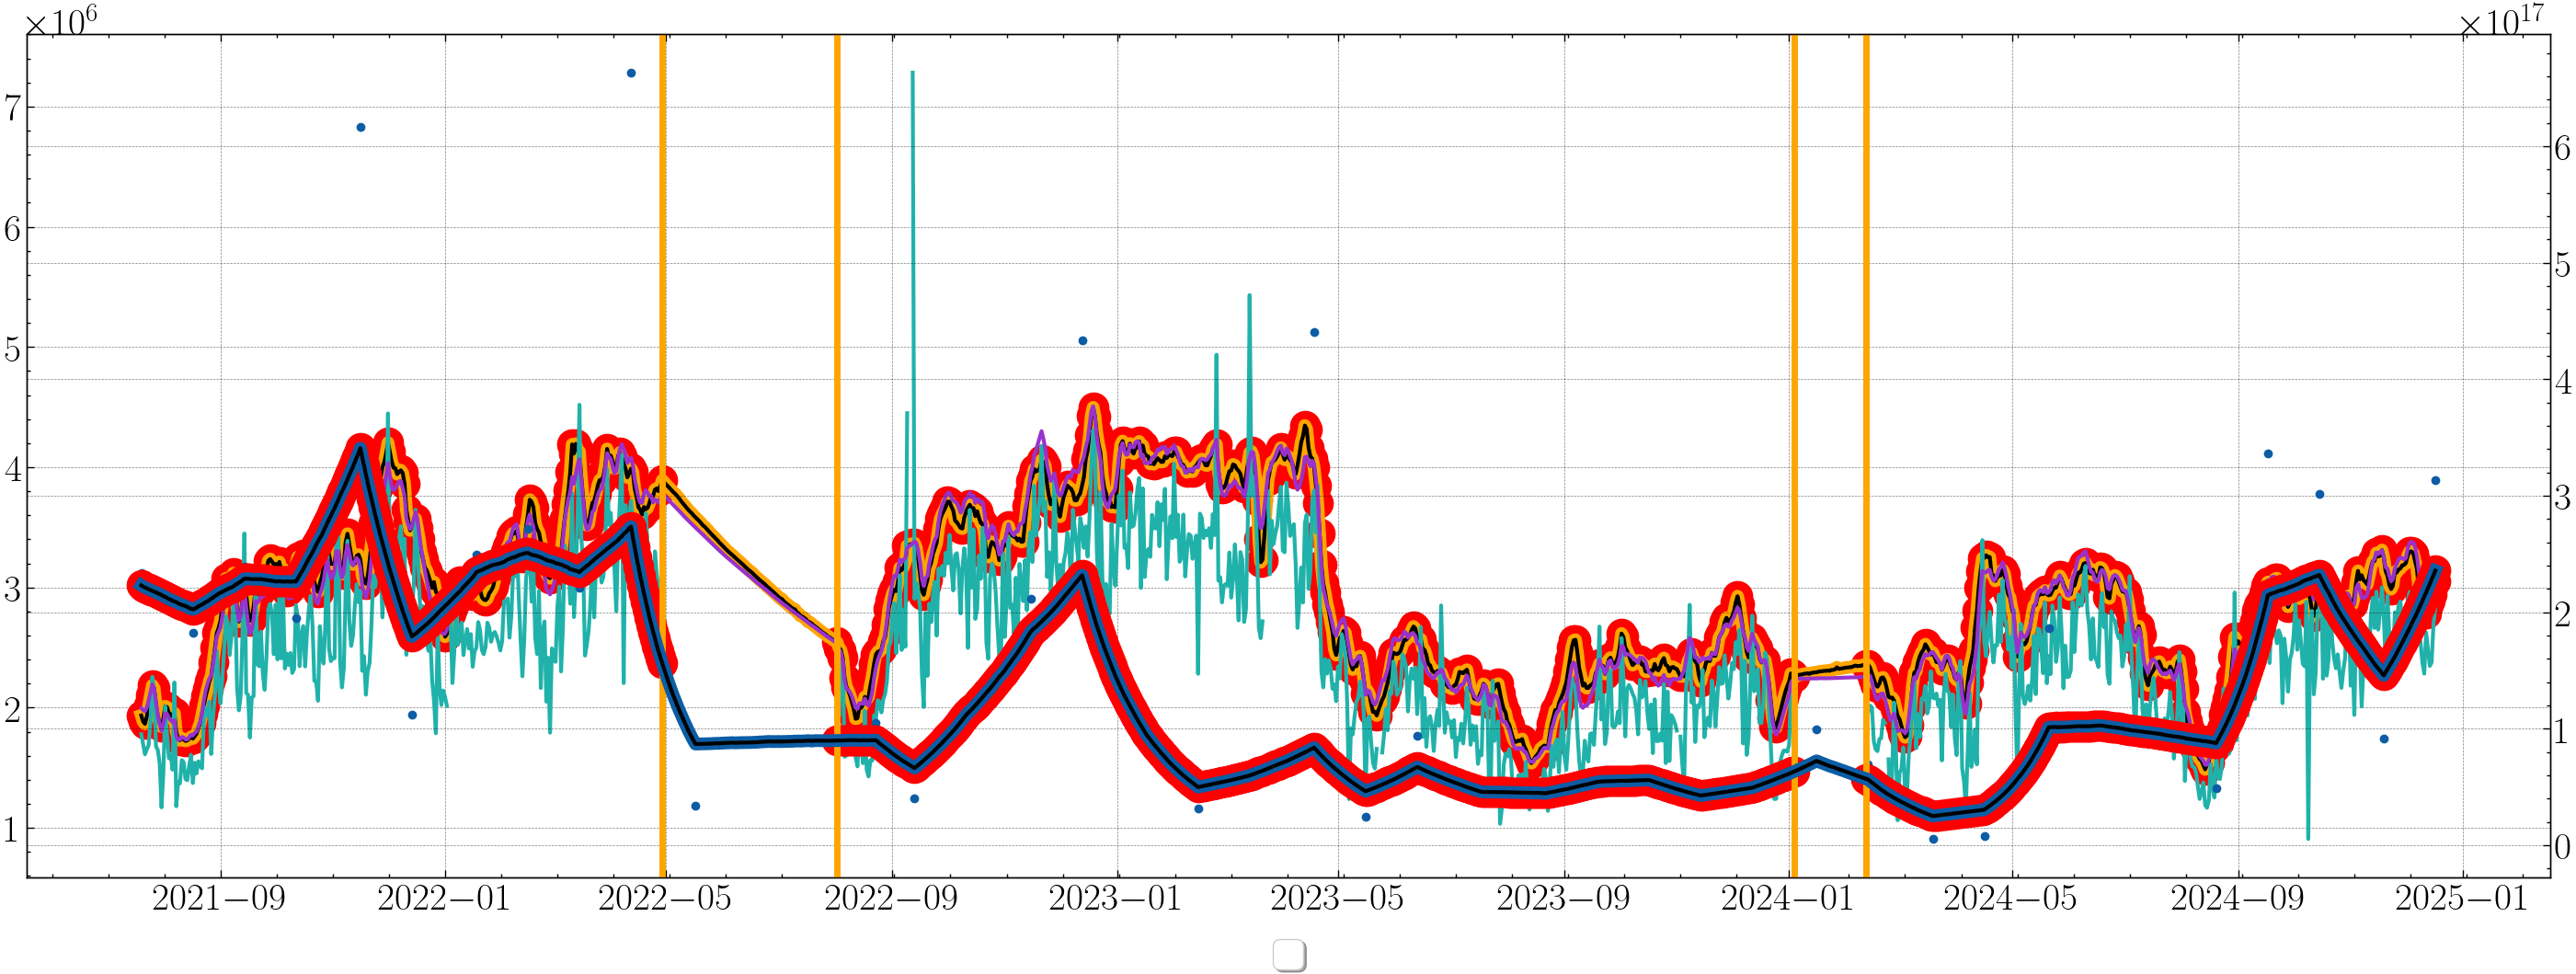

../outputs/files/pmmov_crass/SEC_PMMoV.csv
---------
0.38 0.32 0.895 0.992
---------
../outputs/files/pmmov_crass/SEC_Crassphage.csv
[ 11.21174374 128.6280787   50.29099277  12.40912796  12.6
   1.288071    61.39916306]
4
---------
[0, 1, 2, 3, 4]
['NH4' 'DCO' 'DBO' 'NTK' 'NGL']
(1247, 5) (5,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[1]
['DCO']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[2]
['DBO']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[4]
['NGL']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[5]
['PT']
(1247, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[1]
['DCO']
(1106, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[2]
['DBO']
(1106, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[4]
['NGL']
(1106, 1) (1,)
---------
[ 10.3 120.   60.   12.6  12.6   1.2  60. ]
---------
[5]
[

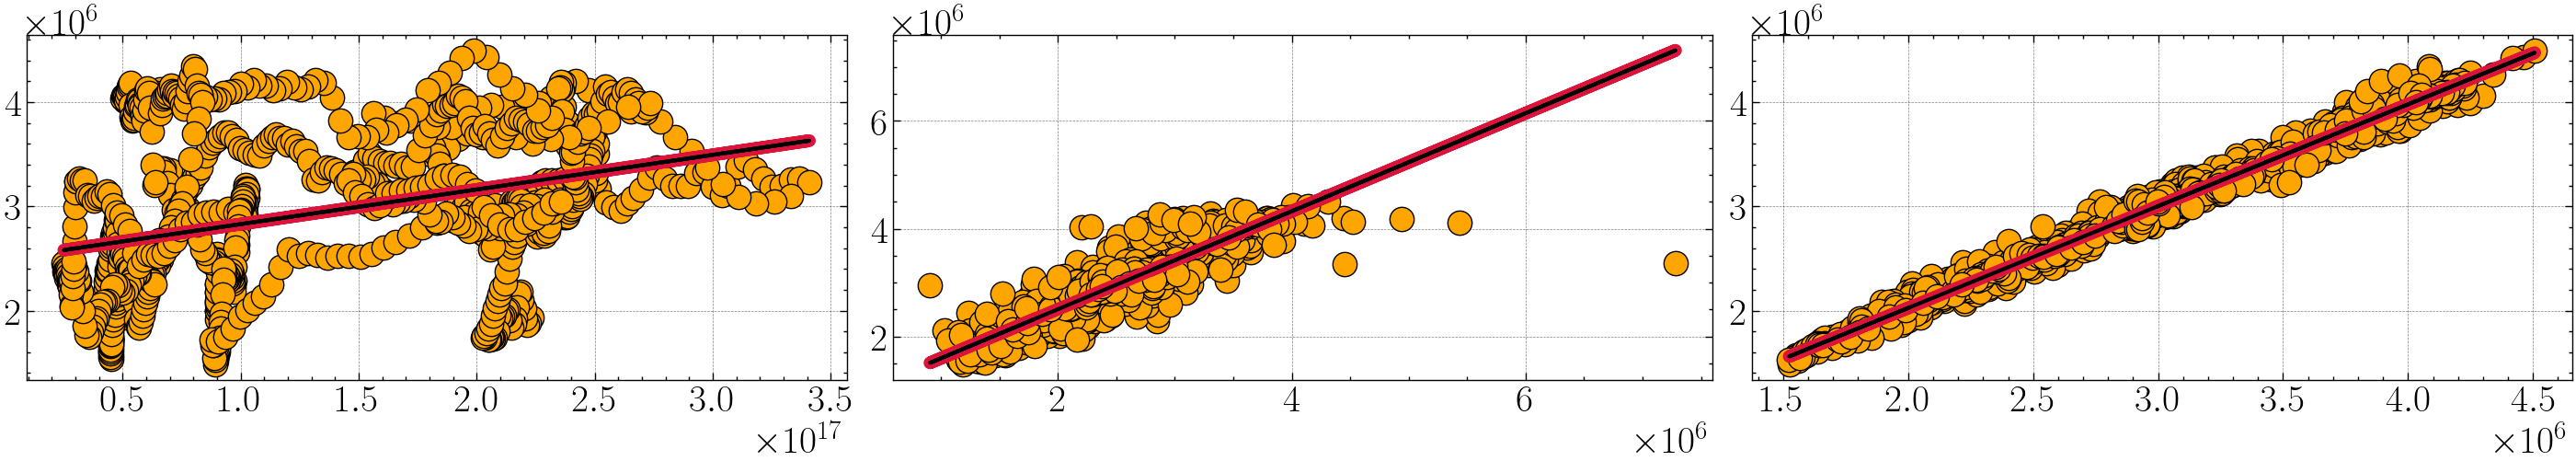

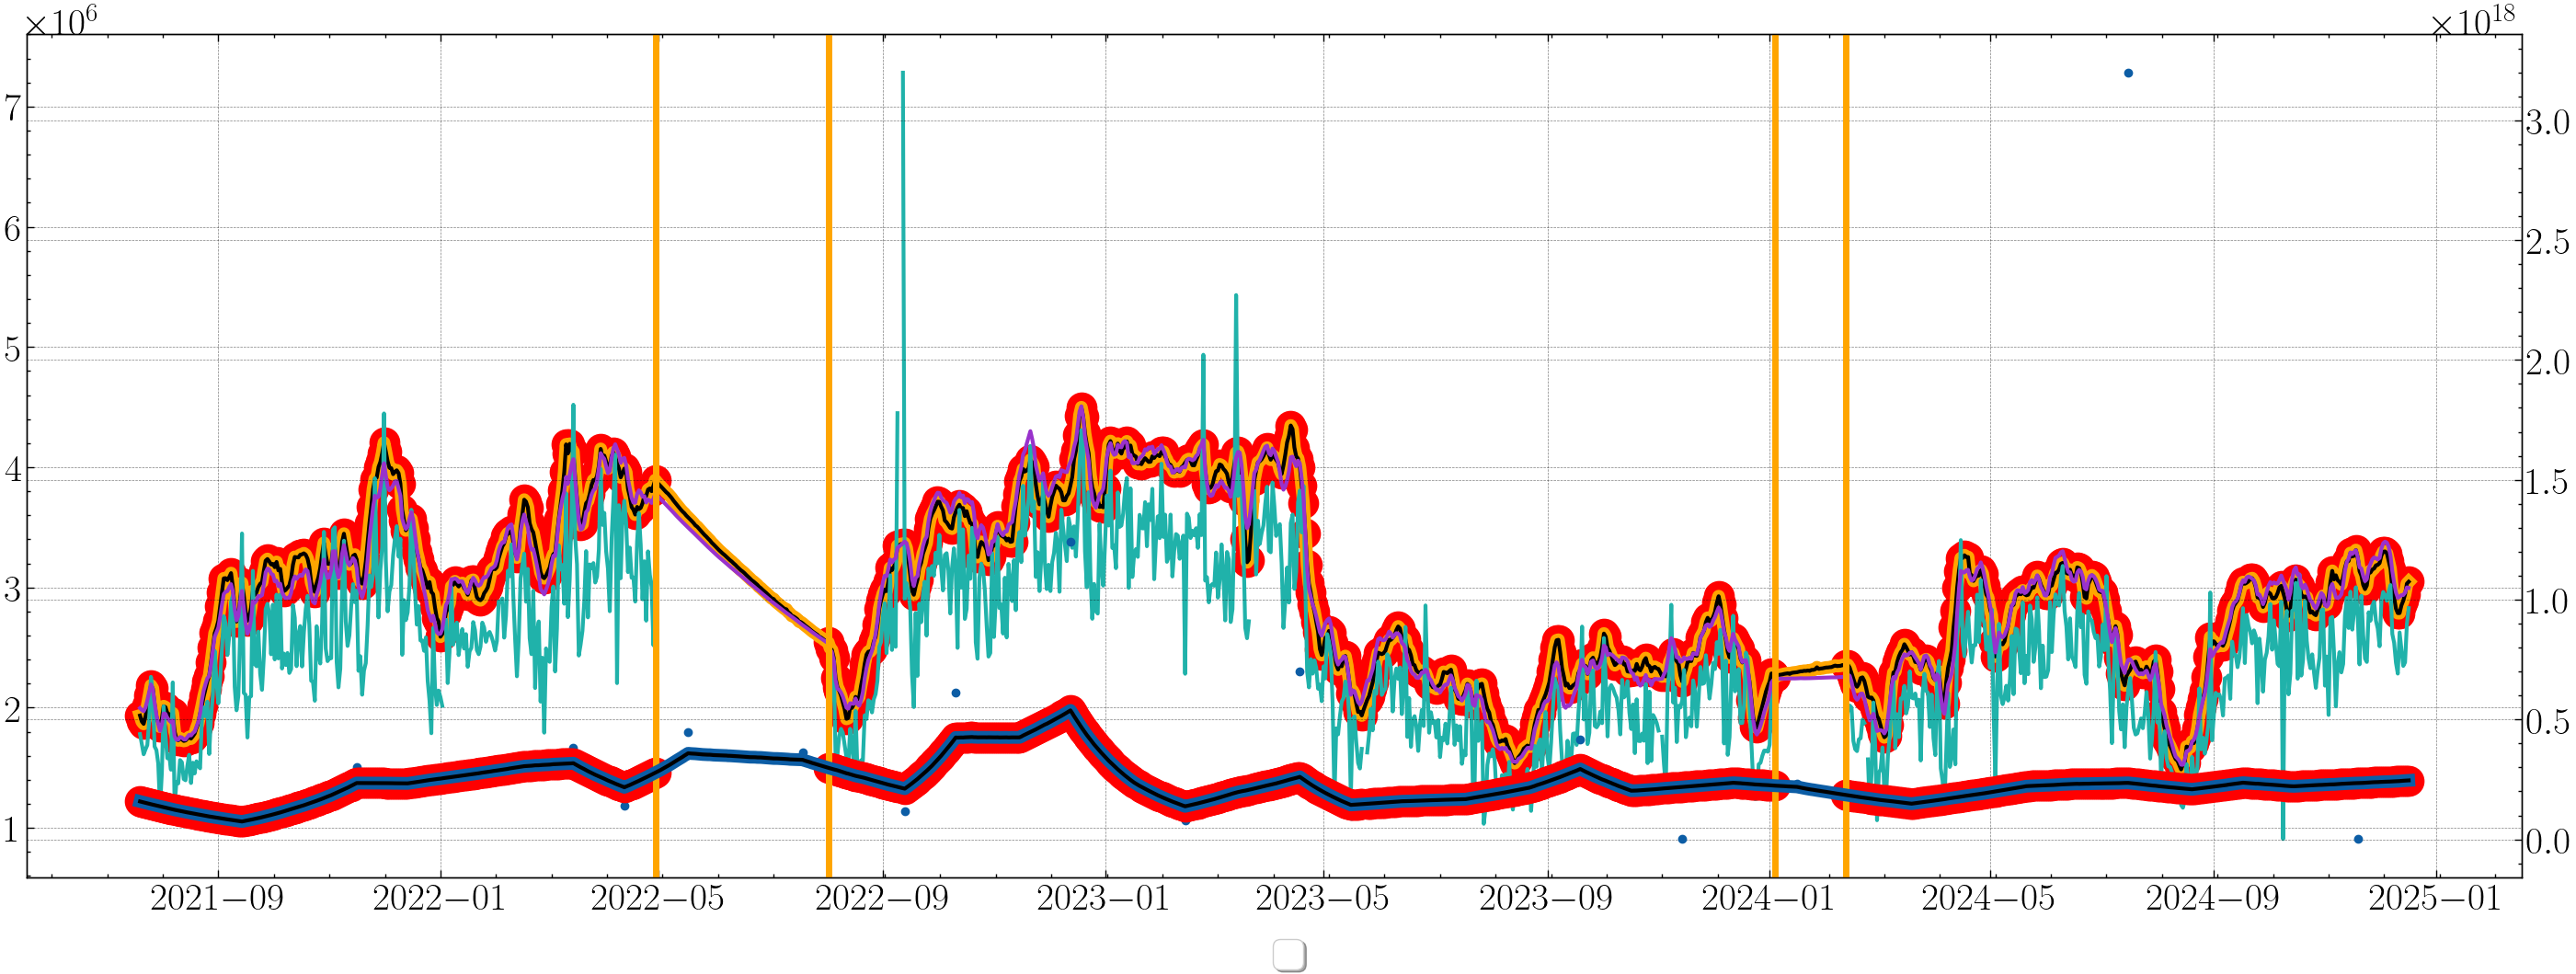

../outputs/files/pmmov_crass/SEC_Crassphage.csv
---------
0.423 0.394 0.895 0.992
---------


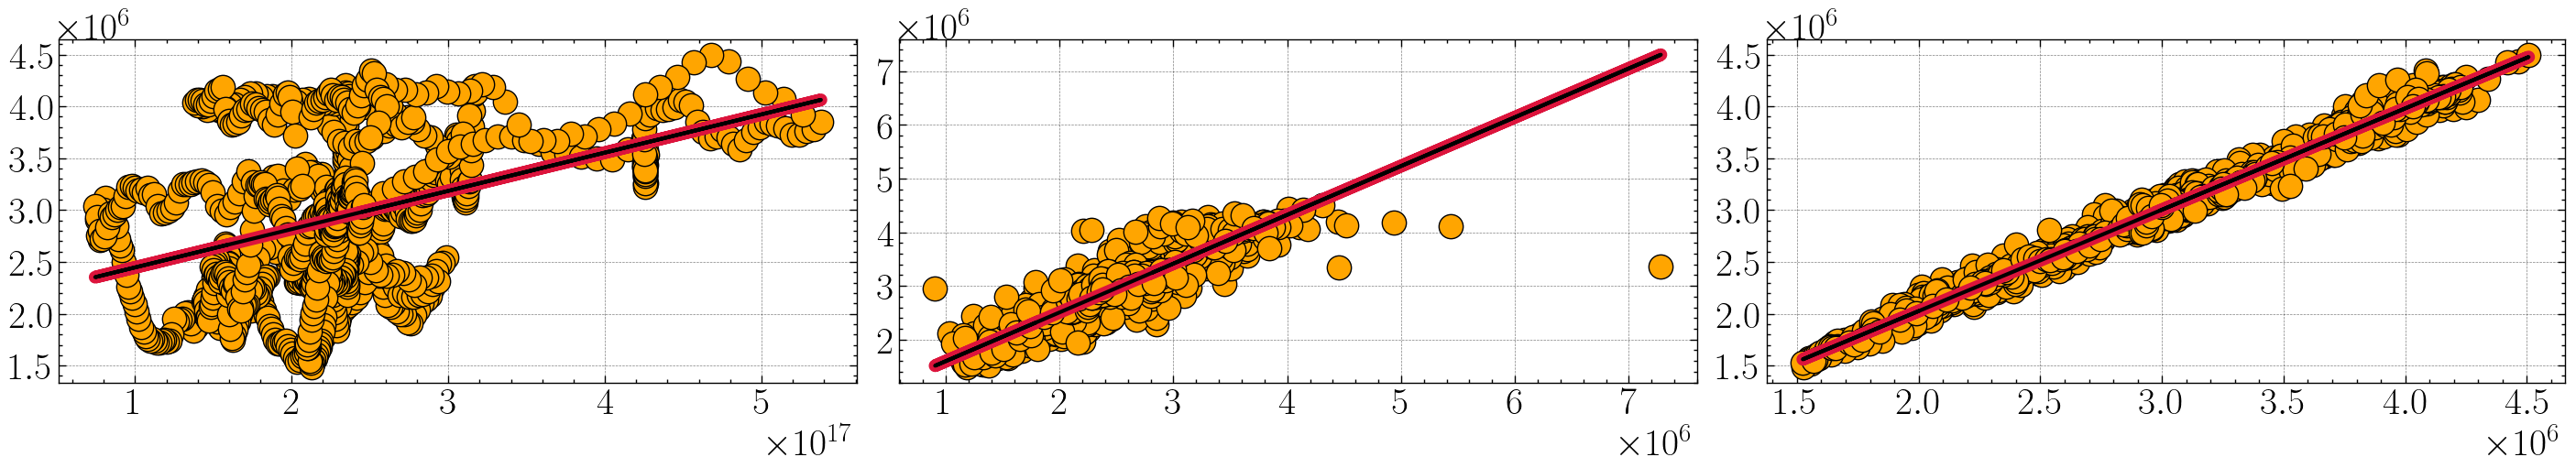

In [11]:
coefs_IAGE = {}

iage_files_dict_ww = {}
iage_files_dict_pop = {}

s1_dict = {}
s2_dict = {}

for file in iage_files:
    print(file)
    
    this_key = file.split('.csv')[0].split('/')[-1]

    data_cp, pop_file, s1, s2 = full_process_IAGE(file)
    corr_our_model_phages, corr_vn_phages, corr_our_model_vn, corr_our_model_vn_smoothed = perform_correlation_computation(s1, s2)

    iage_files_dict_ww[this_key] = data_cp
    iage_files_dict_pop[this_key] = pop_file
    
    coef = s1.muX.mean() / s2.Nt_hat.mean()
    coefs_IAGE[this_key] = coef
    s1_dict[this_key] = s1
    s2_dict[this_key] = s2
    
    print("=========")
    print(file)
    print("=========")
    
    print("---------")
    print(corr_our_model_phages, corr_vn_phages, corr_our_model_vn, corr_our_model_vn_smoothed)
    print("---------")

    


In [12]:
this_key = 'SEC_Crassphage'
s1_temp = s1_dict[this_key]
s2_temp = s2_dict[this_key]

s1_temp = s1_temp.loc[(s1_temp.dateStart<='2023-01-01') | (s1_temp.dateStart>='2023-05-01')]
s2_temp = s2_temp.loc[(s2_temp.dateStart<='2023-01-01') | (s2_temp.dateStart>='2023-05-01')]

perform_correlation_computation(s1_temp, s2_temp)

(0.555, 0.5, 0.883, 0.991)

In [13]:
this_key = 'SEC_PMMoV' 
pop_ref_sig = s2_dict[this_key]
pop_ref_sig = pop_ref_sig.loc[(pop_ref_sig.dateStart<='2023-01-01') | (pop_ref_sig.dateStart>='2023-05-01')]

In [14]:
path_mes = '../outputs/files/pop_estimation_SEC_hierarchical_manuscript/MES_same_sampling_calendar_PMMoV_crAssphages.csv'

mes_SEC = pd.read_csv(path_mes, sep=";")
mes_SEC.dateStart = pd.to_datetime(mes_SEC.dateStart)
mes_SEC.muX = 10**(mes_SEC.muX)
mes_SEC = mes_SEC.loc[mes_SEC.dateStart.isin(pop_ref_sig.dateStart.tolist())]

In [15]:
np.corrcoef(mes_SEC.muX.values, pop_ref_sig.Nt_hat.values)

array([[1.       , 0.7957344],
       [0.7957344, 1.       ]])

In [16]:
temp_s1 = s1_dict['SEC_PMMoV']
temp_s2 = s2_dict['SEC_PMMoV']
temp_s1.muX.mean() / temp_s2.Nt_hat.mean()

44246716677.42455

In [17]:
temp_s1 = s1_dict['SEC_PMMoV'].muX.values
temp_s2 = s2_dict['SEC_PMMoV'].Nt_hat.values

ratio = temp_s1 / temp_s2

In [18]:
np.percentile(ratio, 2.5)*1e-10

1.1764690347936106

In [19]:
np.percentile(ratio, 97.5)*1e-11

1.0708469567714838

In [20]:
np.mean(ratio)*1e-10

4.408064808049405

In [21]:
temp_s1 = s1_dict['SEC_Crassphage'].muX.values
temp_s2 = s2_dict['SEC_Crassphage'].Nt_hat.values

ratio = temp_s1 / temp_s2

In [22]:
np.percentile(ratio, 2.5)*1e-10

3.1590895793036227

In [23]:
np.percentile(ratio, 97.5)*1e-11

1.3223557823894125

In [24]:
np.mean(ratio)*1e-10

8.077889847169493

In [25]:
coefs_IAGE

{'SEC_PMMoV': 44246716677.42455, 'SEC_Crassphage': 78743548006.87402}

In [26]:
iage_files_dict_ww.keys()

dict_keys(['SEC_PMMoV', 'SEC_Crassphage'])

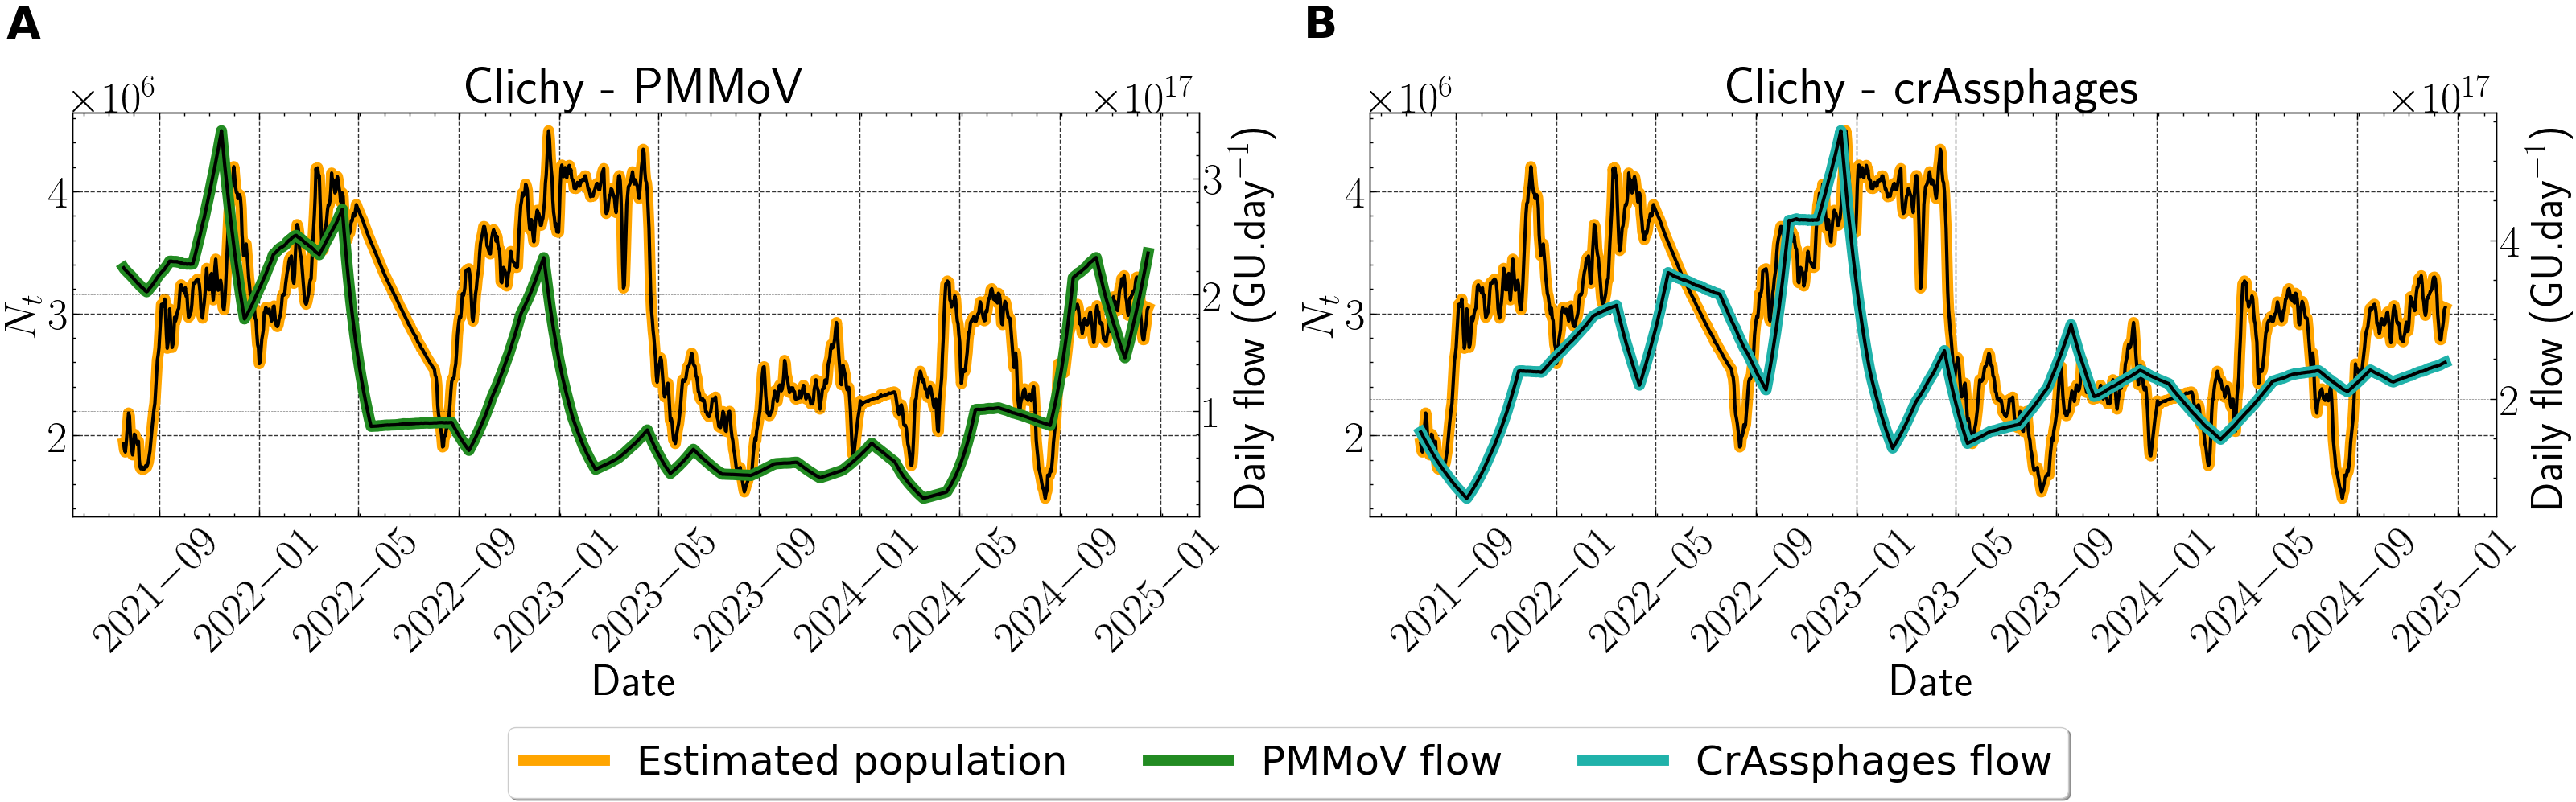

In [30]:
with plt.style.context(['science', 'notebook', 'grid']):

    ratio_factor = 1#0.875
    KEY_SIZE = int(40 * ratio_factor)
    LABEL_SIZE = int(40 * ratio_factor)
    TICK_SIZE = int(40 * ratio_factor)
    TITLE_SIZE = int(46 * ratio_factor)
    LEGEND_SIZE = int(36 * ratio_factor)
    DATES_SIZE = 18
    figsize = (32, 8) #figsize = (32, 10)
    #figsize = (28, 6) #figsize = (32, 10)
    
    plt.rc('axes', labelsize=LABEL_SIZE)
    plt.rc('xtick', labelsize=TICK_SIZE)   
    plt.rc('ytick', labelsize=TICK_SIZE)
    plt.rc('figure', titlesize=TITLE_SIZE)
    plt.rc('legend', fontsize=LEGEND_SIZE)
    plt.rcParams['text.usetex'] = True
    
    fig = plt.figure(figsize=figsize, layout="constrained")
    
    ax_dict = fig.subplot_mosaic(
        """
        AB
        """
    )
    
    ######################################################### A #########################################################
    sub_data_iage = iage_files_dict_pop['SEC_PMMoV'].copy()
    this_molecule = 'Clichy'
    color = 'orange'
    this_letter = 'A'
    ax_dict[this_letter].plot(sub_data_iage.dateStart.values, sub_data_iage.Nt_hat.values, label='Estimated population', color=color, linewidth=10, zorder=3)
    ax_dict[this_letter].plot(sub_data_iage.dateStart.values, sub_data_iage.Nt_hat.values, color='black', linewidth=3, zorder=3)
        
    
    # Cases
    cases_data_iage = iage_files_dict_ww['SEC_PMMoV'].copy()
    ax_cases_1 = ax_dict[this_letter].twinx()

    ax_cases_1.plot(cases_data_iage.dateStart.values, cases_data_iage.muX.values, color='forestgreen', label='PMMoV flow', linewidth=10, zorder=3)
    ax_cases_1.plot(cases_data_iage.dateStart.values, cases_data_iage.muX.values, color='black', linewidth=3, zorder=3)

    
    ax_dict[this_letter].set_ylabel("$N_t$")
    ax_dict[this_letter].set_xlabel("Date")
    ax_dict[this_letter].tick_params(axis='x', labelsize=TICK_SIZE, rotation=45)
    ax_dict[this_letter].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict[this_letter].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict[this_letter].set_title(this_molecule + ' - PMMoV', size=TITLE_SIZE)
    
    ax_cases_1.set_ylabel("Daily flow (GU.day$^{-1}$)")

    ######################################################### B #########################################################
    this_letter = 'B'
    sub_data_iage = iage_files_dict_pop['SEC_Crassphage'].copy()
    this_molecule = 'Clichy'
    color = 'orange'
    ax_dict[this_letter].plot(sub_data_iage.dateStart.values, sub_data_iage.Nt_hat.values, label='Estimated population', color=color, linewidth=10, zorder=3)
    ax_dict[this_letter].plot(sub_data_iage.dateStart.values, sub_data_iage.Nt_hat.values, color='black', linewidth=3, zorder=3)
        
    
    # Cases
    cases_data_iage = iage_files_dict_ww['SEC_Crassphage'].copy()
    ax_cases_B_1 = ax_dict[this_letter].twinx()

    ax_cases_B_1.plot(cases_data_iage.dateStart.values, cases_data_iage.muX.values, color='lightseagreen', label='CrAssphages flow', linewidth=10, zorder=3)
    ax_cases_B_1.plot(cases_data_iage.dateStart.values, cases_data_iage.muX.values, color='black', linewidth=3, zorder=3)

    
    ax_dict[this_letter].set_ylabel("$N_t$")
    ax_dict[this_letter].set_xlabel("Date")
    ax_dict[this_letter].tick_params(axis='x', labelsize=TICK_SIZE, rotation=45)
    ax_dict[this_letter].tick_params(axis='y', labelsize=TICK_SIZE)
    ax_dict[this_letter].grid(linewidth=1, color='black', alpha=0.8)
    ax_dict[this_letter].set_title(this_molecule + ' - crAssphages', size=TITLE_SIZE)
    
    ax_cases_B_1.set_ylabel("Daily flow (GU.day$^{-1}$)")


    

    # Display subplot keys
    plt.rcParams['text.usetex'] = False
    fig.canvas.draw()
    
    # Function to align text with the ylabel of a specific axis
    def align_text_with_ylabel(ax, text, fig, offset=0.175):
        ylabel = ax.yaxis.label
        bbox = ylabel.get_window_extent()
        bbox_fig = fig.transFigure.inverted().transform(bbox)
        ylabel_center_fig_x = (bbox_fig[0, 0] + bbox_fig[1, 0]) / 2
        ylabel_center_fig_y = (bbox_fig[0, 1] + bbox_fig[1, 1]) / 2
        fig.text(ylabel_center_fig_x, ylabel_center_fig_y + offset, text, ha='center', va='center', size=KEY_SIZE, weight='bold')

    # Align text with the ylabels for each subplot
    for n, (key, ax) in enumerate(ax_dict.items()):
        align_text_with_ylabel(ax, key, fig, offset=0.45)
    
    
    # Main legend
    plt.rcParams['text.usetex'] = False
    h1, l1 = ax_dict['A'].get_legend_handles_labels()
    h2, l2 = ax_cases_1.get_legend_handles_labels()
    h3, l3 = ax_cases_B_1.get_legend_handles_labels()
    fig.legend(h1+h2+h3, l1+l2+l3, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=5)
    plt.savefig("../outputs/figs/2025-12-18_" + "crAss_PmmoV_" + "pop_norm.pdf", bbox_inches = 'tight')
    plt.savefig("../outputs/figs/2025-12-18_" + "crAss_PmmoV_" + "pop_norm.jpg", bbox_inches = 'tight')
    
    plt.show()